<a href="https://colab.research.google.com/github/tuhvbulat/MealDemandForecasting/blob/main/meal_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meal Demand Forecasting

[Ссылка на соревнование](https://www.kaggle.com/sureshmecad/meal-demand-forecasting)

---

**Описание бизнес-задачи:**

- Компания по доставке еды имеет различные центры выполнения заказов в нескольких городах. Она хочет, чтобы мы помогли этим центрам **в прогнозировании спроса на 1 ближайшую неделю**, чтобы правильно спланировать запасы продуктов. Также компания просит оценить *экономический эффект* и *точность нашего прогноза*, чтобы понимать, насколько хорош наш алгоритм и насколько можно ему доверять.

- В данном случае необходима оптимизация логистического бизнес-процесса, чтобы эффективно использовать складские помещения и поддерживать оптимальный объем продукции.

**Бизнес-цель:** 

- Оптимизация расчётов потребностей складов в продукции для минимизации возможных потерь.

- Оценка успешности будет происходить с помощью измерения объёма невостребованной продукции на складе и нехватившей продукции, вызвавшей неудовлетворённый спрос. *Критерий успеха:* предсказанный спрос удовлетворяет существующие потребности клиентов, при этом невостребованных запасов на складе должно быть сведено к минимуму.

Это было описание бизнес-кейса. Давайте теперь сформулируем математическую постановку задачи данного бизнес-кейса.

--- 

**Математическая постановка задачи:** 

- Разработка модели машинного обучения на основании данных о динамике спроса в прошлом путем изучения объемов продаж за определенный период времени для решения задачи регрессии по предсказанию спроса на продукцию компании на 1 неделю. Вероятностная модель не требуется. 

- Модель может быть интегрирована в рабочую среду отвественных за расчёт потребностей в продукции складов в виде дополнительной программы. Далее это может быть использовано для организации доставки продукции до складов.

**Метрика качества:**

- Будет использована **MAPE**, поскольку данная метрика может быть легко интерпретирована для бизнес-целей как процент ошибки относительно истинного ответа

---

**Актуальность задачи:**

- Запасы продукции – это залог того, что компания получает прибыль, а значит, её бизнес процветает, поэтому нужно точно знать, когда и сколько её нужно закупить.

- Для компании по доставке еды важно правильное планирование закупок. Если не учесть этот момент, то можно столкнуться с проблемой нехватки или излишка товара и, как следствие, с убытками. Необходимо соблюдать баланс между количеством запасов и оборотом, в котором они используются. С одной стороны, запасов продуктов на складах должно быть достаточно, чтобы удовлетворить существующие потребности клиентов. С другой стороны, неправильное планирование запасов ведёт к тому, что много невостребованной продукции, хранящейся на одном из складов, может стать непригодной к употреблению (истечение срока годности), что приведёт к дополнительным расходам на утилизацию. 

In [ ]:
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm.auto import tqdm

# Set up Screen output
pd.set_option('display.max_columns', 200)

import matplotlib.pyplot as plt
import seaborn as sns
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Игнорируем назойливые предупреждения
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

Установим библиотеку `catboost` и утилиту `shap` для визуализации важности признаков.

*Флаг `-q` позволяет отключить дебажный вывод.*

In [ ]:
!pip install -q catboost shap

     |████████████████████████████████| 76.3 MB 1.3 MB/s 
     |████████████████████████████████| 564 kB 36.2 MB/s 
     |████████████████████████████████| 23.2 MB 1.9 MB/s 


In [ ]:
from termcolor import cprint # For making colorful printing texts

from sklearn.model_selection import train_test_split, GridSearchCV

import catboost
from catboost import CatBoostRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import math 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 0: Data

Перед нами данные из реальной жизни. Поэтому какие-то товары могут быть очень новыми и у них слишком короткая история для прогнозирования продаж для них. Некоторые товары дорогие и покупаются не каждую неделю/месяц. В общем все, что присуще продажам товаров в магазинах.

Однако у нас большая тренировочная выборка (целых 145 недель), что может позволить нам хорошо спрогнозировать спрос на непопулярные товары.

In [ ]:
DATA_DIR = "/content/drive/My Drive/MTS.Teta Summer school/meal_demand_forecasting/data"

train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

meal_info = pd.read_csv(os.path.join(DATA_DIR, "meal_info.csv"))
fulfilment_center_info = pd.read_csv(os.path.join(DATA_DIR, "fulfilment_center_info.csv"))

In [ ]:
# making colorful printing texts
print('\nShape of the Train set:', train.shape)
cprint('*'*35, 'green')

print('\nShape of the Test set:', test.shape)
cprint('*'*35, 'green')

print('\nShape of the Meal Info set:', meal_info.shape)
cprint('*'*35, 'green')

print('\nShape of the Fulfilment Center Info set:', fulfilment_center_info.shape)
cprint('*'*35, 'green')


Shape of the Train set: (456548, 9)
***********************************

Shape of the Test set: (32573, 8)
***********************************

Shape of the Meal Info set: (51, 3)
***********************************

Shape of the Fulfilment Center Info set: (77, 5)
***********************************


### `train` & `test`

Исторические данные о спросе на комбинацию "продукт-центр" (недели: от 1 до 145):

- `id` - Unique ID
- `week` - Week No
- `center_id` - Unique ID for fulfillment center
- `meal_id` - Unique ID for Meal
- `checkout_price` - Final price including discount, taxes & delivery charges
- `base_price` - Base price of the meal
- `emailer_for_promotion` - Emailer sent for promotion of meal
- `homepage_featured` - Meal featured at homepage
- **`num_orders`** - (Target) Orders Count (в train)

In [ ]:
train

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68
456544,1062036,145,61,2304,482.09,482.09,0,0,42
456545,1110849,145,61,2664,237.68,321.07,0,0,501
456546,1147725,145,61,2569,243.50,313.34,0,0,729


In [ ]:
test

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0
...,...,...,...,...,...,...,...,...
32568,1250239,155,61,1543,482.09,484.09,0,0
32569,1039516,155,61,2304,483.09,483.09,0,0
32570,1158107,155,61,2664,322.07,323.07,0,0
32571,1444235,155,61,2569,322.07,323.07,0,0


### `meal_info`

Характеристики продуктов (еды), такие как категория и кухня:

- `meal_id` - Unique ID for the meal
- `category` - Type of meal (beverages/snacks/soups….)
- `cuisine` - Meal cuisine (Indian/Italian/…)

In [ ]:
pd.concat((meal_info.head(), 
           meal_info.tail()))

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian
46,2956,Fish,Continental
47,2104,Fish,Continental
48,2444,Seafood,Continental
49,2867,Seafood,Continental
50,1445,Seafood,Continental


### `fulfilment_center_info`

Информация о центрах выполнения, такая как площадь центра, информация о городе и т.д.

- `center_id` - Unique ID for fulfillment center
- `city_code` - Unique code for city
- `region_code` - Unique code for region
- `center_type` - Anonymized center type
- `op_area` - Area of operation (in km^2)

In [ ]:
fulfilment_center_info

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6
...,...,...,...,...,...
72,53,590,56,TYPE_A,3.8
73,30,604,56,TYPE_A,3.5
74,76,614,85,TYPE_A,3.0
75,68,676,34,TYPE_B,4.1


# Part I: Preparation

Объединим данные со всех таблиц в один датафрейм `all_data`

In [ ]:
train = train.merge(meal_info, on="meal_id", how="left")\
                .merge(fulfilment_center_info, on="center_id", how="left")
test = test.merge(meal_info, on="meal_id", how="left")\
           .merge(fulfilment_center_info, on="center_id", how="left")

display(train, test)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68,Desert,Indian,473,77,TYPE_A,4.5
456544,1062036,145,61,2304,482.09,482.09,0,0,42,Desert,Indian,473,77,TYPE_A,4.5
456545,1110849,145,61,2664,237.68,321.07,0,0,501,Salad,Italian,473,77,TYPE_A,4.5
456546,1147725,145,61,2569,243.50,313.34,0,0,729,Salad,Italian,473,77,TYPE_A,4.5


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
1,1127204,146,55,1993,160.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
2,1212707,146,55,2539,157.14,159.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
3,1082698,146,55,2631,162.02,162.02,0,0,Beverages,Indian,647,56,TYPE_C,2.0
4,1400926,146,55,1248,163.93,163.93,0,0,Beverages,Indian,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32568,1250239,155,61,1543,482.09,484.09,0,0,Desert,Indian,473,77,TYPE_A,4.5
32569,1039516,155,61,2304,483.09,483.09,0,0,Desert,Indian,473,77,TYPE_A,4.5
32570,1158107,155,61,2664,322.07,323.07,0,0,Salad,Italian,473,77,TYPE_A,4.5
32571,1444235,155,61,2569,322.07,323.07,0,0,Salad,Italian,473,77,TYPE_A,4.5


Число столбцов в `train` по типу. Как видно, многие имеют числовой тип. Однако, некоторые из них по смыслу являются категориальными. Для нашего удобства создадим списки с именами категориальных и числовых признаков.

In [ ]:
train.dtypes.value_counts()

int64      9
float64    3
object     3
dtype: int64

In [ ]:
train.columns.values

array(['id', 'week', 'center_id', 'meal_id', 'checkout_price',
       'base_price', 'emailer_for_promotion', 'homepage_featured',
       'num_orders', 'category', 'cuisine', 'city_code', 'region_code',
       'center_type', 'op_area'], dtype=object)

Признак `op_area (Area of operation (in km^2))` скорее всего категориальный (всего 30 различных значений). Однако с ростом `op_area` важность признака интуитивно должна повышаться, поэтому оставим его числовым.

In [ ]:
display(train["op_area"].nunique(),
        train["op_area"].value_counts())

30

4.0    52548
3.9    48533
3.8    40080
4.4    26060
4.5    25688
2.8    25503
4.1    23346
7.0    20686
4.8    18648
3.4    17258
3.6    16821
5.1    13366
4.2    12608
2.7    12430
3.0    11184
2.0     9512
6.7     7046
6.3     7015
5.6     6993
3.7     6801
3.5     6666
3.2     6333
5.0     6164
5.3     6053
4.6     5983
4.7     5975
2.4     5021
2.9     4712
1.9     4083
0.9     3432
Name: op_area, dtype: int64

In [ ]:
cat_features = [
    "center_id", 
    "meal_id", 
    "emailer_for_promotion", 
    "homepage_featured", 
    "category", 
    "cuisine", 
    "city_code", 
    "region_code", 
    "center_type"
]

num_features = [
    "week", 
    "checkout_price", 
    "base_price", 
    "op_area"
]

In [ ]:
# Все признаки
feature_cols = num_features + cat_features
# Целевая переменная
target_col = 'num_orders'

In [ ]:
train_X = train[feature_cols]
train_y = train[target_col]
# После выделения названий признаков в список, порядок столбцов изменился
test = test[feature_cols]

# Part II: EDA

Посмотрим на данные чуть более пристально.

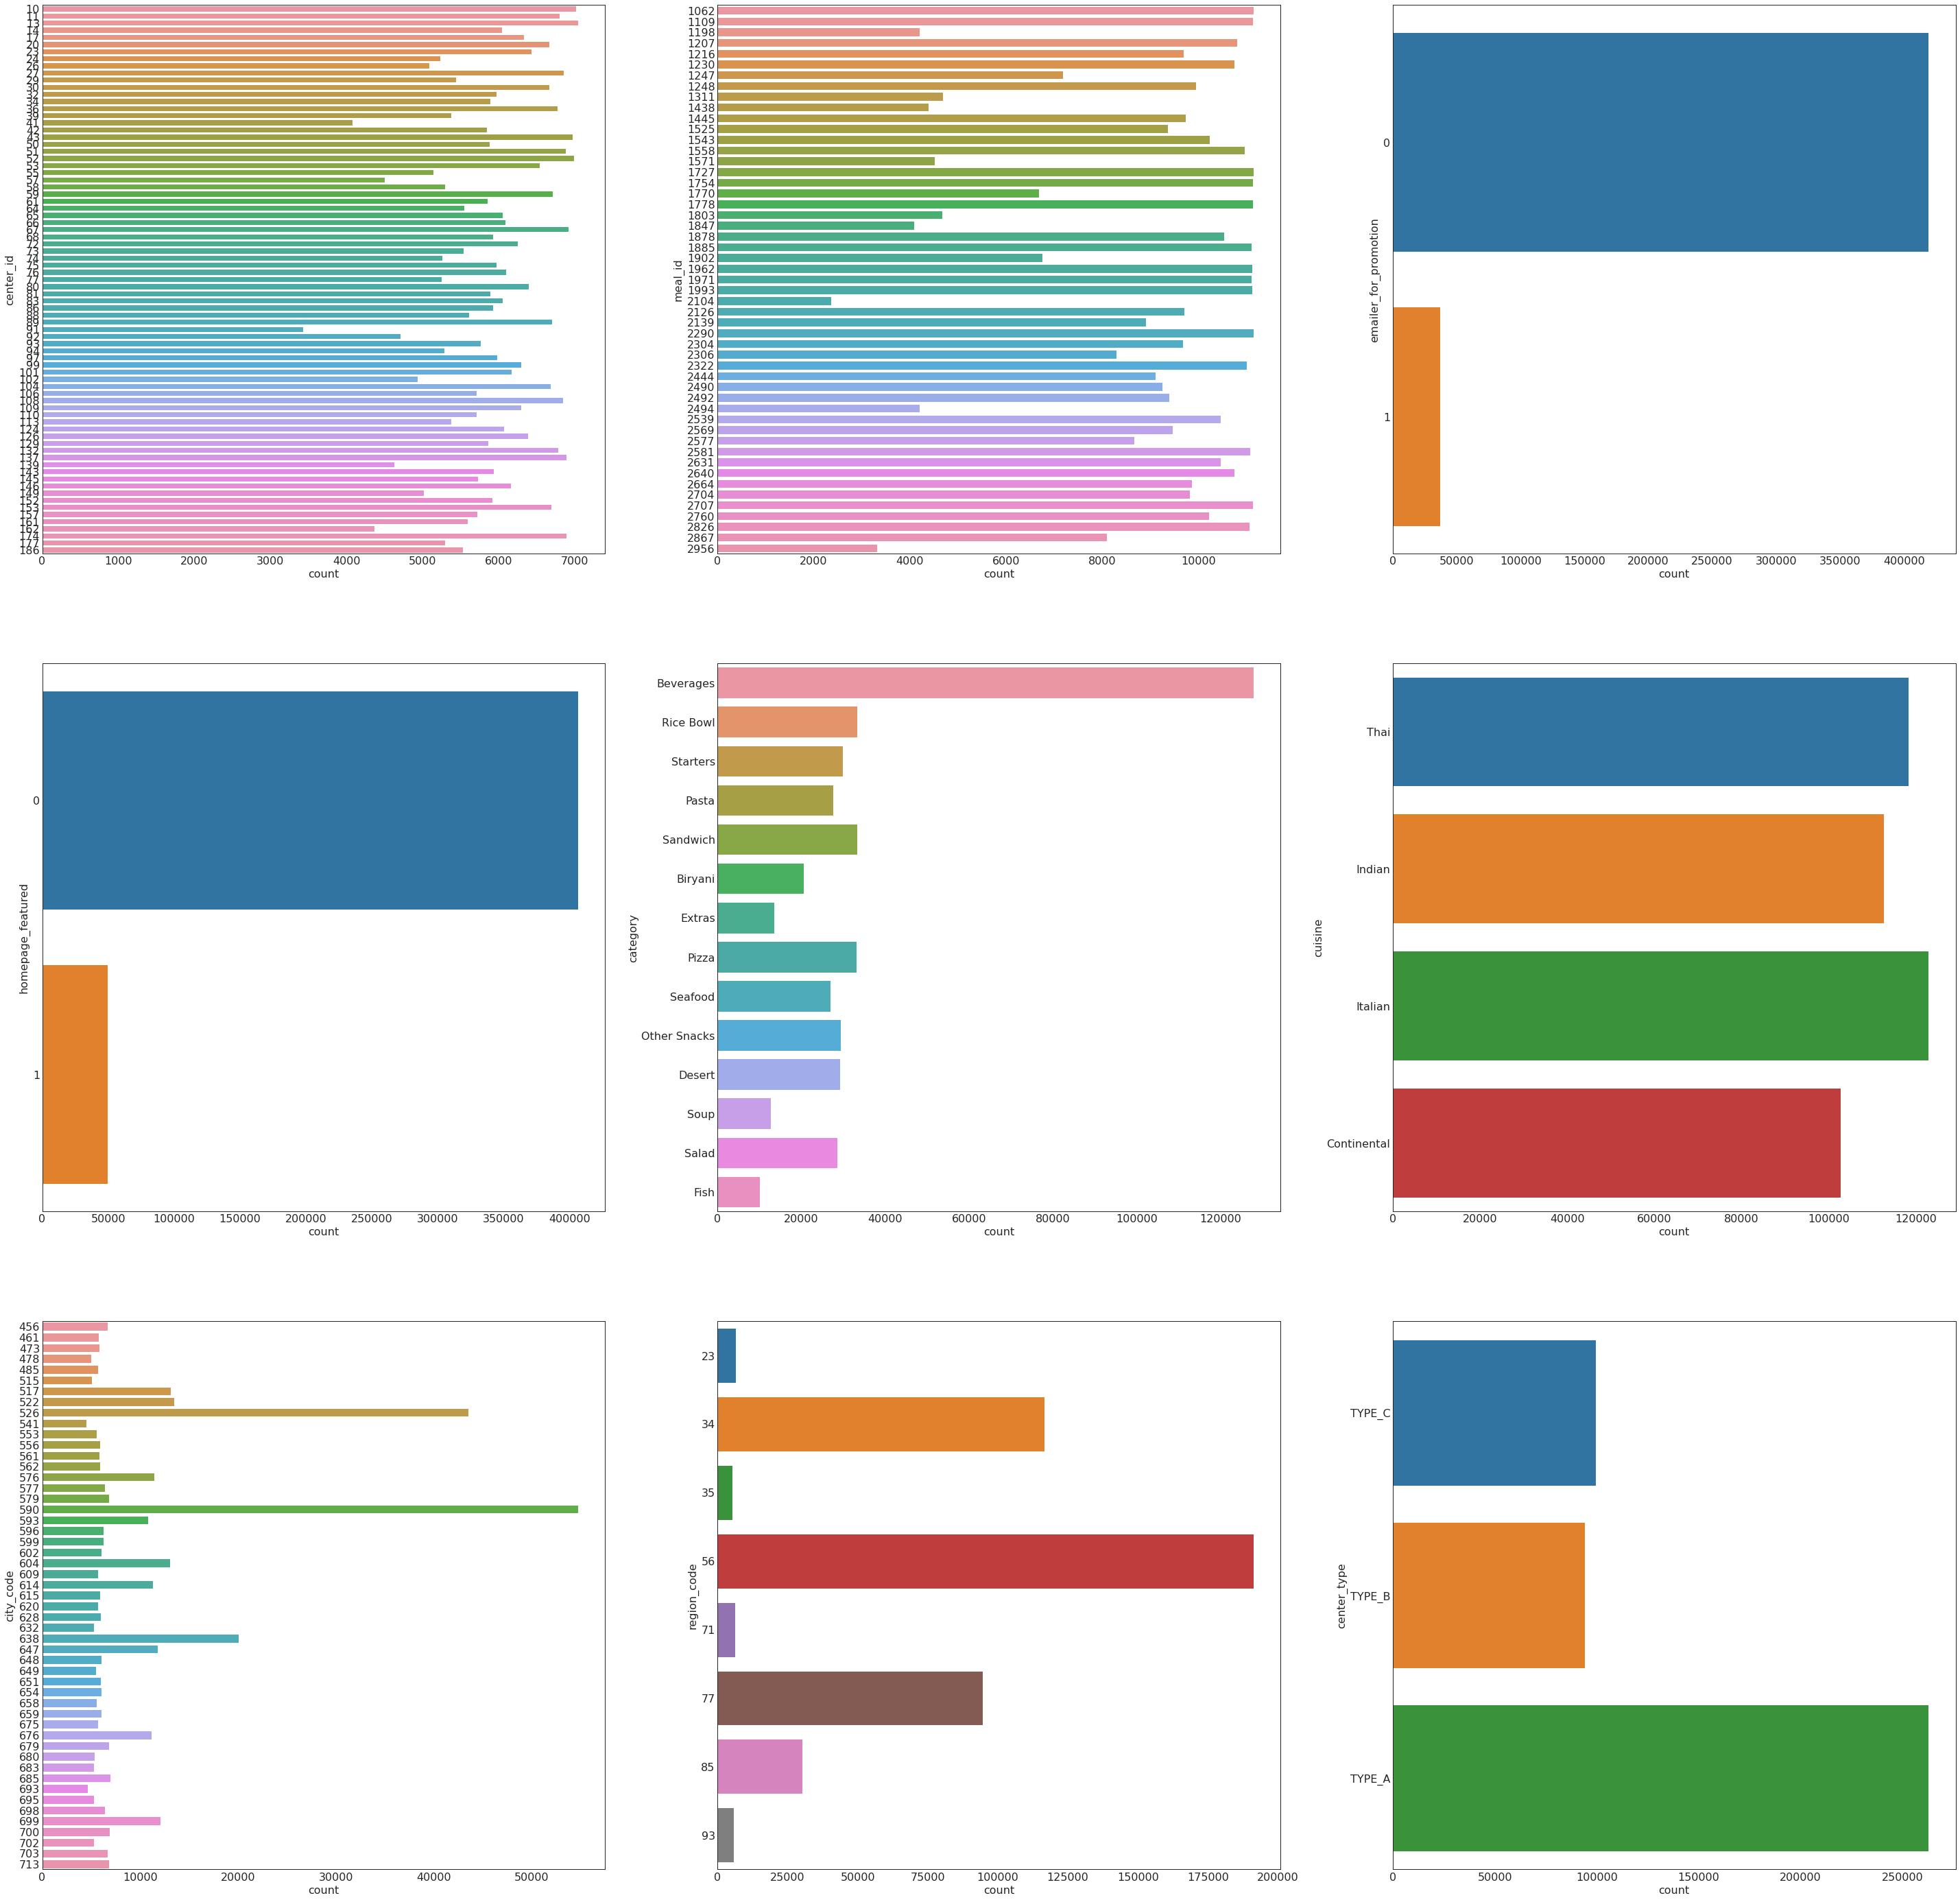

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(50, 50))

for i, feature in enumerate(cat_features):
    sns.countplot(y=train_X[feature],
                  ax=ax.reshape(-1)[i])
    
plt.show()

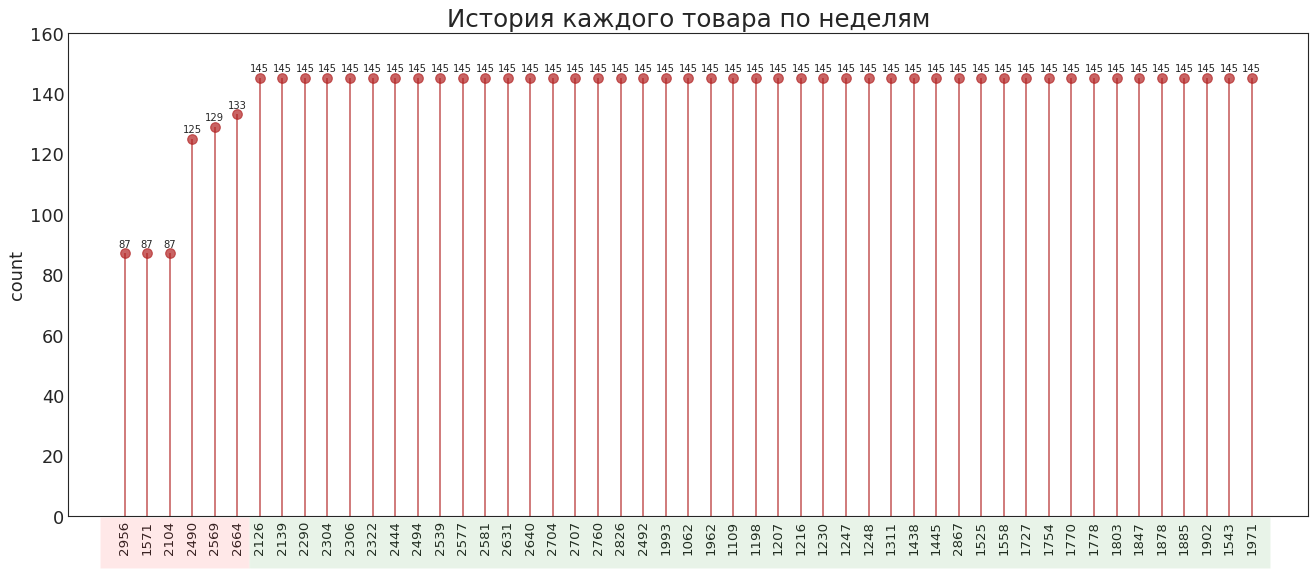

In [ ]:
# Prepare Data
df = train_X[["meal_id", "week"]].groupby('meal_id').nunique()
df.sort_values('week', inplace=True)
df.reset_index(inplace=True)

# Draw plot
fig, ax = plt.subplots(figsize=(20,8), dpi= 80)
ax.vlines(x=df.index, ymin=0, ymax=df.week, color='firebrick', alpha=0.7, linewidth=1.5)
ax.scatter(x=df.index, y=df.week, s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title("История каждого товара по неделям")
ax.set_ylabel('count')
ax.set_xticks(df.index)
ax.set_xticklabels(df.meal_id, rotation=90, fontdict={'horizontalalignment': 'center', 'size':12})
ax.set_ylim(0, 160)

# Draw plot
import matplotlib.patches as patches

# Annotate
for row in df.itertuples():
    ax.text(row.Index, row.week+1.5, s=row.week, horizontalalignment= 'center', verticalalignment='bottom', fontsize=9)

# Add patches to color the X axis labels
p1 = patches.Rectangle((.145, 0.044), width=.093, height=.08, alpha=.09, facecolor='red', transform=fig.transFigure)
p2 = patches.Rectangle((.238, 0.044), width=.638, height=.08, alpha=.09, facecolor='green', transform=fig.transFigure)
fig.add_artist(p1)
fig.add_artist(p2)
plt.show()

Видим, что не по всем товарам есть полная история в 145 недель (`2956`, `1571`, `2104`, `2490`, `2569`, `2664`). Тем не менее, история всё равно большая.

In [ ]:
print(f"Всего уникальных центров: {train_X.center_id.nunique()}")
print(f"Всего уникальных видов еды: {train_X.meal_id.nunique()}")

Всего уникальных центров: 77
Всего уникальных видов еды: 51


Теперь посмотрим сколько уникальной продукции есть в каждом центре.

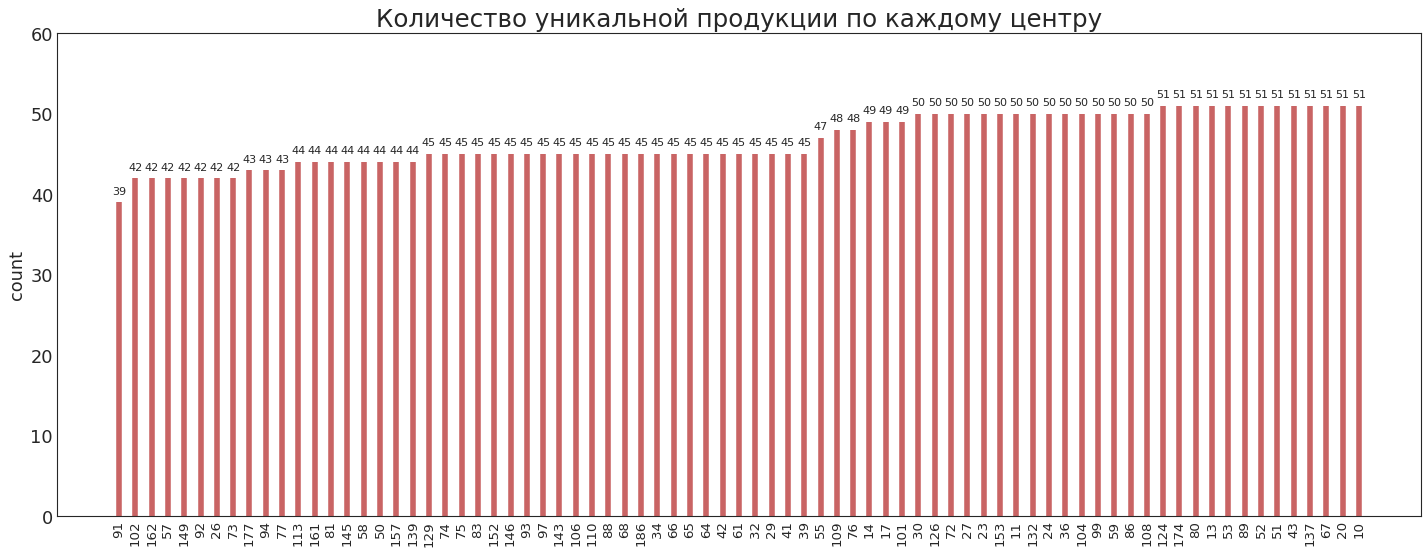

In [ ]:
df = train_X[["center_id", "meal_id"]].groupby("center_id").nunique()
df.sort_values('meal_id', inplace=True)
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(22,8), facecolor='white', dpi= 80)
ax.vlines(x=df.index, ymin=0, ymax=df.meal_id, color='firebrick', alpha=0.7, linewidth=5)

# Annotate Text
for i, meal_id in enumerate(df.meal_id):
    ax.text(i, meal_id+1, meal_id, horizontalalignment='center')


# Title, Label, Ticks and Ylim
ax.set_title('Количество уникальной продукции по каждому центру', fontdict={'size':22})
ax.set(ylabel='count', ylim=(0, 60))
plt.xticks(df.index, df.center_id, rotation=90, horizontalalignment='center', fontsize=12)

plt.show()

### 2.1 Исследование данных на наличие пропусков и некорректных значений. 

**Либо удалим их, либо сделаем imputing (проинтерполируем).**


Данные могут иметь пропущенные значения не случайно, а в виду некоторых закономерностей. В таких случаях пропуски можно выразить на основе информации, содержащейся в наборе данных. Благодаря описанию данных, приложенных к соревнованию, можно заменить их подходящими значениями.

In [ ]:
cprint("Dtypes in Train :", 'green')
cprint('*'*35, 'green')
print('\n', train_X.info())

cprint("Dtypes in Test :", 'green')
cprint('*'*35, 'green')
print('\n', test.info())

Dtypes in Train :
***********************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   checkout_price         456548 non-null  float64
 2   base_price             456548 non-null  float64
 3   op_area                456548 non-null  float64
 4   center_id              456548 non-null  int64  
 5   meal_id                456548 non-null  int64  
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   category               456548 non-null  object 
 9   cuisine                456548 non-null  object 
 10  city_code              456548 non-null  int64  
 11  region_code            456548 non-null  int64  
 12  center_type            456548 non-null  object 
dtypes: float64(3), int64(7), object(3)


### 2.2 Распределение целевой переменной. Поиск аномалий.

**Можно убрать выбросы из датасета.**

num_orders


count    456548.000000
mean        261.872760
std         395.922798
min          13.000000
25%          54.000000
50%         136.000000
75%         324.000000
max       24299.000000
Name: num_orders, dtype: float64

-----------------------------------


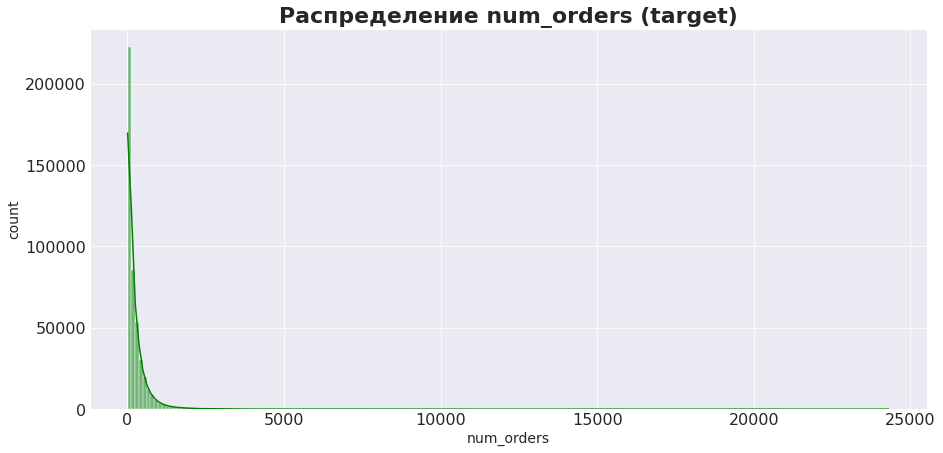

In [ ]:
with sns.axes_style('darkgrid'):
    fig = plt.figure(figsize=(15,7))

    sns.histplot(data=train_y, bins=200, kde=True, color="Green")
    
    plt.title("Распределение num_orders (target)", fontsize = 22, fontweight="bold")
    plt.xlabel("num_orders", fontsize=14)
    plt.ylabel('count', fontsize=14)    

    print("num_orders")
    display(train_y.describe())
    print("-" * 35)
    
    plt.show()

**Вывод по данным:**

* В обучающей выборке отсутствуют пропуски, но были обнаружены выбросы. 
    * При этом в категориальных признаках наблюдается существенный дисбаланс, что может повлиять на возможность модели получить значимую связь между целевой переменной и данными признаками.

* Количество заказов имеет отрицательную корреляцию со следующими признаками: итоговая цена и базовая цена (при этом между данными показателями также наблюдается высокая положительная корреляция)

* Количество заказов имеет положительную корреляцию со следующими признаками: отправка промо по e-mail и показы продукции на главной странице (при этом между данными показателями также наблюдается высокая положительная корреляция)

* Объём выборки позволяет провести обучение (456548), что говорит о её достаточности.

* Непротиворечивость данных не наблюдается.

* Удовлетворяет ли ожиданиям? 

    * Необходимо провести предобработку датасета перед обучением. Также необходимо расширить датасет с положительными примерами по промоакциям и наличию товара на главной странице сайта, либо убрать эту информацию совсем.

* Возможно, стоит перейти от просто порядкового перечисления недели к неделе в месяце и конкретному месяцу, чтобы модель смогла найти новые закономерности

# Part III: Prediction

## 3.1 Прогнозирование среднего значения количества заказов для каждого склада

In [ ]:
class AveragePredictor():
    def __init__(self):
        self.predictions = pd.DataFrame()
        
    def fit(self, df):
        self.predictions = df.groupby(['center_id', 'meal_id'], as_index=False).agg({'num_orders':'mean'})
        self.predictions["num_orders"] = self.predictions["num_orders"].apply(lambda x: math.ceil(x))
        
    def predict(self, df):
        df_for_pred = df.loc[:, ['center_id', 'meal_id']].drop_duplicates()
        preds = df_for_pred.merge(self.predictions, on=['center_id', 'meal_id'], how='inner')
        return preds

In [ ]:
# подготовка данных для обучения и теста
border = int(0.8 * len(train))
train_shuffle = train.sample(frac=1)

# обучение модели
avg_pred = AveragePredictor()
avg_pred.fit(train_shuffle[:border])

# обучение модели
avg_pred = AveragePredictor()
avg_pred.fit(train_shuffle[:border])# предсказания
y_pred = avg_pred.predict(train_shuffle[border:])

# проверка качества
for_test = train_shuffle[['center_id', 'meal_id', 'num_orders']]
for_test = for_test.merge(y_pred, how='inner', on=['center_id', 'meal_id'], suffixes=['_true', '_pred'])
mean_absolute_percentage_error(for_test.num_orders_true, for_test.num_orders_pred)

0.7642046579534086

## 3.2 CatBoost

**Ключевые гиперпараметры:**
- `iterations` -- количество итераций;
- `loss_function` -- функция ошибок (LogLoss или CrossEntropyLoss);
- `learning_rate` -- длина градиентного шага. Вычисляется автоматически на основе количества итераций и размера обучающей выборки;
- `depth` -- глубина деревьев;
- `rsm` -- использовать ли метод случайных подпространств при построении деревьев (по умолчанию отключено);
- `one_hot_max_size` -- максимальная мощность категориального признака, при которой к нему всё ещё применяется one-hot encoding. 

С полным списком гиперпараметров можно ознакомиться в официальной документации: https://catboost.ai/docs/concepts/python-reference_parameters-list.html 

---

Сильная сторона `CatBoost` в том, что он показывает достойное качество при значениях гиперпараметров по умолчанию. Тем не менее, это не означает, что его не следует пытаться конфигурировать! Мы рассмотрим несколько основных настроек, которые позволяют существенно улучшить качество предсказания и, в целом, ощущения от работы с этим инструментом:

- **Использование GPU для ускорения вычислений.** Одна из самых сильных сторон `CatBoost` -- возможность обучения на GPU. На малых данных прирост качества незаметен, но на достаточно больших, production-level данных возможен 40-кратный прирост при сравнении достаточно мощной GPU (V100) против достаточно мощного CPU. Для того, чтобы использовать GPU, достаточно выставить `task_type='GPU'`. Если в вашем распоряжении несколько GPU, `CatBoost` умеет использовать их для распределённого обучения. От вас требуется только перечислить их названия / номера через запятую в параметре `devices`.

- **Вычисление метрик качества на каждой итерации.** LogLoss, который алгоритм пытается минимизировать, это неинтерпретируемая величина. Но `CatBoost` умеет в реальном времени подсчитывать привычные метрики качества в духе ROC-AUC, F1, Precision, Recall, Accuracy etc. Достаточно просто перечислить их в параметре `eval_metric` в конструкторе.

- **Автоматическая детекция переобучения**. Если у вас есть валидационная выборка, вы можете использовать поведение функции ошибок на ней для того, чтобы понять, что алгоритм начал переобучаться, и остановить его обучение. Степень уверенности в этом задаётся параметром `od_pval` (от 0 до 1, причём чем меньше, тем меньше вероятность ложного срабатывания, но и тем выше шанс потратить много итераций впустую). Количество шагов, которые нужно подождать после того, как алгоритм начал переобучаться, контролируется парамеров `od_wait`. 

- **Автоматический выбор лучшей модели по метрикам качества на валидационной выборке.** Достаточно прописать `use_best_model=True` в конструкторе объекта.

- **Early stopping.** Предыдущий метод ранней остановки обучения алгоритма опирается на т.н. *детекцию разладки* -- статистический метод определения момента начала аномального поведения системы. Есть более простой, более интерпретируемый способ -- т.н. *early stopping*, который останавливает обучение, если метрика качества на валидационной выборке не улучшается на протяжении наперёд заданного количества шагов, которое контролируется параметром `early_stopping_rounds`. 

- **Checkpoints.** Если ваш алгоритм обучается достаточно долго (скажем, несколько часов), вы захотите сохранять промежуточные результаты на диск, чтобы потом, в случае непредвиденной ошибки в духе отказа оборудования, начать не с нуля, а с последнего чекпоинта. Для сохранения чекпоинтов достаточно задать параметр `train_dir` в конструкторе и прописать `save_snapshot=True`, `snapshot_file=...` в параметрах метода `fit`.

- **Baseline.** Если у вас уже есть достаточно хороший алгоритм другой природы (скажем, метрический), то вы можете обучить бустинг корректировать его ошибки. Достаточно просто передать предсказания имеющейся модели через параметр `baseline`. Типичный пример такой ситуации -- бустинг на огромном количестве сложных признаков (категориальные, эмбеддинговые, текстовые etc) поверх линейной модели, в которой признаки были подобраны экспертами в предметной области. Условно говоря, ясно, что время доставки можно неплохо приблизить через расстояние и то, сколько, в среднем, занимает доставка в этот район, но есть множество факторов, которые в линейную модель не добавишь, и именно тут выручает бустинг.

In [ ]:
catboost_params = dict(
    iterations=1000,
    depth=4,
    custom_metric="MAPE",
    od_pval=0.05,
    od_wait=20,
    max_ctr_complexity=4,
    verbose=250,
    random_seed=2021,
    task_type="GPU",
    devices="0",
)

kf = KFold(n_splits=4)
models = []
scores = []
Y_predict = []
MAPE_metrics = []

for train_index, test_index in kf.split(train_X):

    # Переведём обучающую и валидационную выборки в нативный 
    # для алгоритмов из catboost формат catboost.Pool
    train_pool = catboost.Pool(
        train_X.iloc[train_index],
        label=train_y.iloc[train_index],
        cat_features=cat_features
    )
    val_pool = catboost.Pool(
        train_X.iloc[test_index],
        label=train_y.iloc[test_index],
        cat_features=cat_features
    )

    # Обучение алгоритма
    model = CatBoostRegressor(
        **catboost_params
    )
    model = model.fit(
        train_pool,
        eval_set=val_pool
    )

    # Сохраним предсказания алгоритма
    Y_predict.append(model.predict(test))
    scores.append(model.score(val_pool))
    
    # Сохраним модель
    models.append(model)
    MAPE_metrics.append((
        model.best_score_["learn"]["MAPE"],
        model.best_score_["validation"]["MAPE"]
    ))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.116639
0:	learn: 360.2728839	test: 414.4542049	best: 414.4542049 (0)	total: 58.9ms	remaining: 58.8s
250:	learn: 175.1867047	test: 227.7647925	best: 227.3757293 (235)	total: 12.3s	remaining: 36.7s
500:	learn: 162.7908774	test: 225.7318474	best: 224.7985875 (464)	total: 24.3s	remaining: 24.2s
bestTest = 224.7985875
bestIteration = 464
Shrink model to first 465 iterations.
Learning rate set to 0.116639
0:	learn: 372.0826309	test: 381.0092670	best: 381.0092670 (0)	total: 58.4ms	remaining: 58.3s
250:	learn: 176.5566485	test: 210.7915953	best: 210.7889777 (248)	total: 12.3s	remaining: 36.7s
500:	learn: 164.1520020	test: 204.3146123	best: 204.3146123 (500)	total: 27.4s	remaining: 27.3s
750:	learn: 156.9017794	test: 201.5212482	best: 201.5212482 (750)	total: 41s	remaining: 13.6s
999:	learn: 152.2272042	test: 199.7825079	best: 199.7622874 (997)	total: 53.1s	remaining: 0us
bestTest = 199.7622874
bestIteration = 997
Shrink model to first 998 iterations.
Learning rate set to

In [ ]:
metrics = [
        (model.best_score_["learn"]["MAPE"], 
        model.best_score_["validation"]["MAPE"]) 
        for model in models
]

In [ ]:
metrics

[(0.6019205538081428, 0.689698769351744),
 (0.5901135167240539, 0.5635946959574897),
 (0.5984151721177182, 0.6143506542576027),
 (0.6202240783006387, 0.6374268833726137)]

In [ ]:
train_MAPE, val_MAPE = np.mean(metrics, axis=0)
print(f"Training MAPE: {train_MAPE}, Validation MAPE: {val_MAPE}")

Training MAPE: 0.6026683302376383, Validation MAPE: 0.6262677507348625


Метрика MAPE говорит нам о том, что в среднем прогноз модели ошибается на 10%.

Модель `CatBoostRegressor` оптимальна по результату метрики качества и по времени обучения.

**Что можно сказать о моделях?**

В качестве baseline модели была выбрана модель AveragePredictor, которая выдаёт в качестве ответа среднее значение заказов для каждого вида продукции в каждом отдельном центре. На данной моделе качество по метрике MAPE составило 0,76, что говорит о том, что прогноз модели в среднем ошибается на 76%.

Далее была рассморена модель RandomForest, которая дала качество предсказаний по метрике MAPE 0,59. Наблюдается сокращение ошибки на 22%.

В качестве основной модели для дальнейшего прогнозирования была выбрана модель CatBoostRegressor. Данная модель оптимальна как по результату метрики качества, так и по времени обучения. Без подбора параметров её качество составило по метрике MAPE ..., а после подбора 0,1. Улучшение качества модели по сравнению с самой простой базовой моделью позволило сократить ошибку на 87%. 

# Part IV: Post-hoc анализ

## 5.1 Проанализируем важности признаков с помощью метода SHAP-values.

Модель catboost хранит в себе поле с значениями важности признаков. Ознакомиться с алгоритмом их вычисления можно в официальной документации: https://catboost.ai/docs/concepts/fstr.html#fstr__regular-feature-importance

Мы обучили 5 моделей catboost на кросс-валидации и получаем ответы усреднением предсказаний каждой модели. Чтобы проанализировать значимость признаков, усредним их важность по каждой модели.

In [ ]:
feature_importances = np.mean(
    [list(model.feature_importances_) for model in models],
    axis=0
)

In [ ]:
sorted(
    zip(train_X.columns, feature_importances), 
    key=lambda p: p[1], 
    reverse=True
)

[('meal_id', 28.18494630192866),
 ('center_id', 14.815281838714592),
 ('emailer_for_promotion', 11.549236242930183),
 ('checkout_price', 10.612228644773316),
 ('homepage_featured', 10.355636378784263),
 ('category', 9.052215649960292),
 ('week', 3.8521376828321823),
 ('base_price', 2.622801019579111),
 ('op_area', 2.424074408391491),
 ('cuisine', 2.3570830518516783),
 ('center_type', 1.7977418947688548),
 ('region_code', 1.700910922075077),
 ('city_code', 0.6757059634103323)]